# Agriculture Crop Yield: Soil Type Prediction

By: Jaeyoung Oh

GitHub: https://github.com/BlueJayVRStudio/CSCA5632_final



##### dataset: https://www.kaggle.com/datasets/samuelotiattakorah/agriculture-crop-yield

The author of the dataset also posted a preliminary EDA. We will use this as a reference and adjust it to the needs of this project

##### EDA reference: https://www.kaggle.com/code/samuelotiattakorah/eda-on-agriculture-crop-yield

## Initial Project Setup

In [187]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

In [188]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Iterative Data Cleaning and EDA

In [241]:
num_tests = 4
tests_passed = 0

In [242]:
# import data
df_crop_yield = pd.read_csv('./data/crop_yield.csv')

### Data Description

In [243]:
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


There are **no null values**, so conveniently we do not have to fill in any missing values. However, we still have numerous preprocessing steps to ensure that our data is ready for clustering tasks.
> - Separate "Soil_Type" from rest of the data frame since we'll be using that as target labels,
> - "Region" and "Crop" are non-ordinal categorical data, thus we need to convert them to binary, one-hot encoding,
> - "Weather_Condition" is also categorical, but one could argue that it is ordinal since cloud cover is directly proportional to sunlight and precipitation. Using just one of those two relationships should suffice,
> - For the rest of the numerical columns, we will perform quick outlier analysis and drop them as we have sufficient data. We will also ensure that no column has over-influence by using standard scaling,
> - Random sample portion of the dataset, since we will run into memory issues with 1 million data points,
> - Lastly we will check for class imbalance on the soil types to ensure that we are working with balanced dataset.

In [244]:
df_crop_yield.head(10)

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251
5,South,Silt,Soybean,797.471182,37.704974,False,True,Rainy,74,5.898416
6,West,Clay,Wheat,357.902357,31.593431,False,False,Rainy,90,2.652392
7,South,Sandy,Rice,441.131154,30.887107,True,True,Sunny,61,5.829542
8,North,Silt,Wheat,181.587861,26.752729,True,False,Sunny,127,2.943716
9,West,Sandy,Wheat,395.048968,17.646199,False,True,Rainy,140,3.707293


In [245]:
# Sanity Check 1: Check unprocessed crop yield dataframe shape
assert df_crop_yield.shape == (1000000, 10), f"expected (1000000, 10), but got {df_crop_yield.shape}"
tests_passed += 1
print ("1. Tests Passed")

1. Tests Passed


### Separate Target Labels

In [246]:
df_labels = df_crop_yield.Soil_Type
df_crop_yield = df_crop_yield.drop(columns=['Soil_Type'])

In [247]:
df_labels

0          Sandy
1           Clay
2           Loam
3          Sandy
4           Silt
           ...  
999995      Silt
999996    Chalky
999997     Peaty
999998      Silt
999999     Sandy
Name: Soil_Type, Length: 1000000, dtype: object

In [248]:
# confirm labels were extracted and print unique target labels
print(df_labels.unique())

['Sandy' 'Clay' 'Loam' 'Silt' 'Peaty' 'Chalky']


In [249]:
# confirm that labels have been dropped
df_crop_yield

,Region,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251
...,...,...,...,...,...,...,...,...,...
999995,West,Rice,302.805345,27.987428,False,False,Sunny,76,1.347586
999996,South,Barley,932.991383,39.661039,True,False,Rainy,93,7.311594
999997,North,Cotton,867.362046,24.370042,True,False,Cloudy,108,5.763182
999998,West,Wheat,492.812857,33.045505,False,False,Sunny,102,2.070159


In [250]:
# Sanity Check 2: Check labels shape and (-)labels crop yield dataframe shape
assert df_labels.shape == (1000000,), f"expected (1000000,), but got {df_labels.shape}"
assert df_crop_yield.shape == (1000000, 9), f"expected (1000000, 9), but got {df_crop_yield.shape}"
tests_passed += 1
print ("2. Tests Passed")

2. Tests Passed


### One-hot encode Region and Crop

In [251]:
df_crop_yield = pd.get_dummies(df_crop_yield, columns =['Region', 'Crop'])
# confirm one-hot encoding for region and crop 
df_crop_yield

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,Region_West,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
0,897.077239,27.676966,False,True,Cloudy,122,6.555816,False,False,False,True,False,True,False,False,False,False
1,992.673282,18.026142,True,True,Rainy,140,8.527341,False,False,True,False,False,False,False,True,False,False
2,147.998025,29.794042,False,False,Sunny,106,1.127443,False,True,False,False,True,False,False,False,False,False
3,986.866331,16.644190,False,True,Rainy,146,6.517573,False,True,False,False,False,False,False,False,True,False
4,730.379174,31.620687,True,True,Cloudy,110,7.248251,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,302.805345,27.987428,False,False,Sunny,76,1.347586,False,False,False,True,False,False,False,True,False,False
999996,932.991383,39.661039,True,False,Rainy,93,7.311594,False,False,True,False,True,False,False,False,False,False
999997,867.362046,24.370042,True,False,Cloudy,108,5.763182,False,True,False,False,False,True,False,False,False,False
999998,492.812857,33.045505,False,False,Sunny,102,2.070159,False,False,False,True,False,False,False,False,False,True


In [252]:
# Sanity Check 3: Re-check labels shape and one-hot encoded crop yield dataframe shape
assert df_labels.shape == (1000000,), f"expected (1000000,), but got {df_labels.shape}"
assert df_crop_yield.shape == (1000000, 17), f"expected (1000000, 17), but got {df_crop_yield.shape}"
tests_passed += 1
print ("3. Tests Passed")

3. Tests Passed


### Convert Weather Condition to Ordinal Ranking

In [253]:
print(df_crop_yield.Weather_Condition.unique())

['Cloudy' 'Rainy' 'Sunny']


In [254]:
weather_ranking = {'Rainy': 0, 'Cloudy': 1, 'Sunny': 2}

In [255]:
df_crop_yield['Weather_Condition'] = df_crop_yield['Weather_Condition'].map(weather_ranking)

In [256]:
# Sanity Check 4: Repeat previous checks and check data type of weather condition
assert df_labels.shape == (1000000,), f"expected (1000000,), but got {df_labels.shape}"
assert df_crop_yield.shape == (1000000, 17), f"expected (1000000, 17), but got {df_crop_yield.shape}"
assert df_crop_yield.Weather_Condition.dtype == np.int64, "Weather condition not converted to ordinal ranking"
tests_passed += 1
print ("4. Tests Passed")

4. Tests Passed


### Outlier Analysis and Miscellaneous Cleaning on Numerical Data

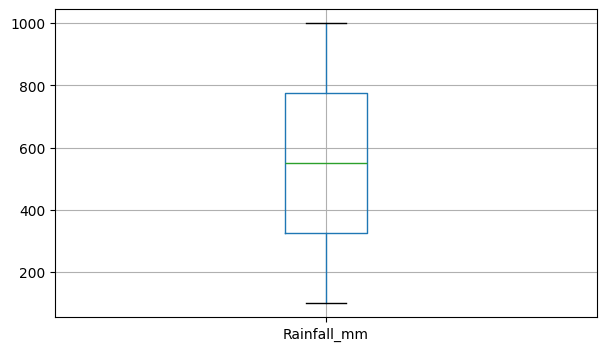

In [265]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Rainfall_mm']].boxplot()
plt.xticks(rotation=0)
plt.show()

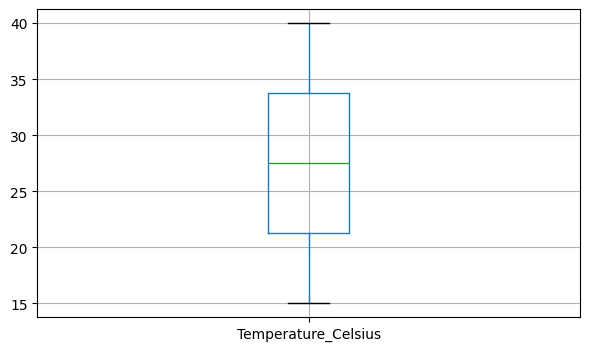

In [266]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Temperature_Celsius']].boxplot()
plt.xticks(rotation=0)
plt.show()

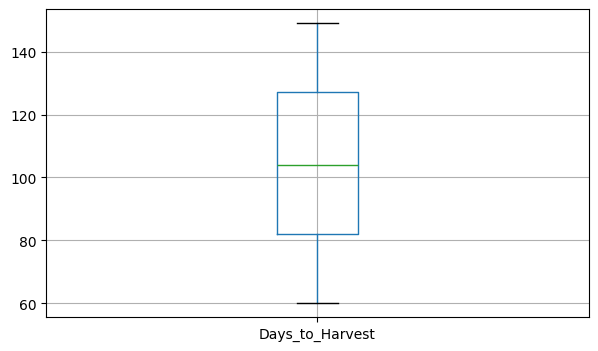

In [269]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Days_to_Harvest']].boxplot()
plt.xticks(rotation=0)
plt.show()

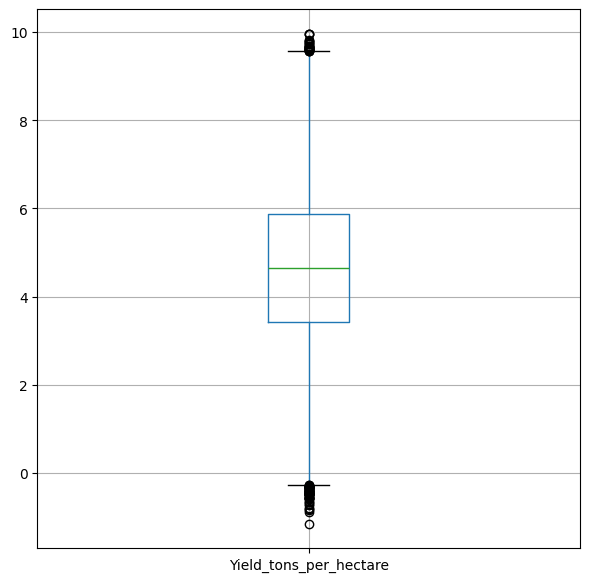

In [271]:
plt.figure(figsize=(7, 7))
df_crop_yield[['Yield_tons_per_hectare']].boxplot()
plt.xticks(rotation=0)
plt.show()

In [276]:
Q1 = df_crop_yield['Yield_tons_per_hectare'].quantile(0.25)
Q3 = df_crop_yield['Yield_tons_per_hectare'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < lower_bound) | (df_crop_yield['Yield_tons_per_hectare'] > upper_bound)]
outliers

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,Region_West,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
11596,957.380991,36.324216,True,True,2,73,9.727004,False,False,False,True,False,False,False,False,False,True
39669,147.755191,20.390486,False,False,1,72,-0.469229,True,False,False,False,True,False,False,False,False,False
54745,119.136310,15.984143,False,False,1,93,-0.290180,False,True,False,False,True,False,False,False,False,False
77504,120.422223,22.809881,False,False,0,120,-0.841617,False,False,False,True,False,False,False,False,False,True
93760,108.811480,17.936402,False,False,0,88,-0.434482,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942403,987.281001,23.821032,True,True,0,114,9.826285,False,False,True,False,False,False,True,False,False,False
947118,110.727929,23.191667,False,False,0,80,-0.507013,False,True,False,False,False,True,False,False,False,False
949892,107.476604,15.473496,False,False,2,80,-0.309650,False,True,False,False,False,False,False,False,True,False
966078,948.730680,38.383078,True,True,1,82,9.650875,False,False,True,False,False,False,False,False,False,True


In [277]:
negatives = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < 0)]
negatives

,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare,Region_East,Region_North,Region_South,Region_West,Crop_Barley,Crop_Cotton,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Wheat
756,101.019421,33.804131,False,False,0,117,-0.007103,True,False,False,False,False,True,False,False,False,False
7799,108.804894,18.004082,False,False,2,86,-0.061283,False,False,True,False,False,False,False,True,False,False
8421,168.120735,38.473430,False,False,1,111,-0.119911,True,False,False,False,False,False,False,False,True,False
9553,156.607973,16.610257,False,False,2,129,-0.193093,False,True,False,False,False,False,False,False,False,True
15435,177.481344,27.719742,False,False,2,94,-0.009811,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975666,116.114046,16.257818,False,False,2,70,-0.471038,False,False,True,False,True,False,False,False,False,False
982738,235.792353,31.699429,False,False,2,68,-0.255772,False,False,False,True,False,False,False,False,False,True
987054,100.467398,15.735951,False,False,0,96,-0.120282,False,False,False,True,True,False,False,False,False,False
995837,105.575189,15.864764,False,False,0,111,-0.051633,True,False,False,False,False,False,True,False,False,False


Rainfall, temperature and days-to-harvest are all within normal ranges, and thus do not require processing besides scaling. Yield in tons per hectare, on the other hand, has 84 outliers and 231 negative numbers, some of which are subset of the outliers. We will drop the outliers and negative numbers sequentially.

In [257]:
assert tests_passed == num_tests, f"{tests_passed} out of {num_tests} tests passed. {num_tests-tests_passed} cases failed. Please check test cases."
print("All Tests Passed")

All Tests Passed


In [18]:
sample_crop_yield = df_crop_yield.sample(10000, random_state=0)

In [45]:
model=AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
model.fit(sample_crop_yield.iloc[:, 8:])
print(model.labels_[0:20])

[0 3 5 3 0 0 1 1 3 3 5 2 3 0 1 5 1 2 2 2]


In [48]:
print(sample_crop_yield.Soil_Type[0:20])

157105      Clay
374554      Loam
688694     Peaty
265381    Chalky
955415      Silt
4280       Sandy
514674     Peaty
800352      Silt
94727      Peaty
753889      Clay
334658    Chalky
676584      Loam
796710      Silt
385008      Silt
568106      Silt
25532       Silt
840001     Peaty
726752     Sandy
939105      Silt
608171      Silt
Name: Soil_Type, dtype: object
